## Price imputation and interpolation using deep learning methods

In this project we will test different deep learning architectures for missing data imputation and interpolation in price data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Masking, SimpleRNN, LSTM, GRU
from keras.models import Model
from keras.layers import Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
readRDS = robjects.r['readRDS']

In [2]:
# Set the desired inputs
category = 'chocolates'
store_id = '1501'
barcode = '7290080177616'

In [3]:
# Import the data
data = readRDS('G:/retail data/rds data/data by store/'+category+'/'+store_id+'.rds')
data = pandas2ri.rpy2py_dataframe(data)

data['Date'] = pd.to_datetime(data['Date'], utc=True, unit='d').apply(lambda x: x.strftime('%Y-%m-%d'))
data['Date'] = pd.to_datetime(data['Date'], errors='coerce').sort_values()
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Weekday'] = data['Date'].dt.weekday

data = data[data['Barcode']==barcode]
data

,Barcode,ProductDescription,Manufacturer,Category,ChainID,ChainName,SubChainID,SubChainName,StoreID,StoreName,Price,Discount,FinalPrice,DiscountDescription,DiscountID,PriceSetDate,Date,Year,Month,Weekday
3,7290080177616,אצבעות שוקולד חלב במילוי קרם חלבי קינדר 8 * 12...,פררו - קינדר,שוקולד חלב,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,8.2,None,8.2,None,None,2018-01-01 04:35:15,2018-01-01,2018,1,0
118,7290080177616,אצבעות שוקולד חלב במילוי קרם חלבי קינדר 8 * 12...,פררו - קינדר,שוקולד חלב,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,8.2,6,6.0,2 יחידות ב-12 ₪. \nעד ה-29/01/2018.\n\nהרשת רש...,0,2018-01-02 04:35:49,2018-01-02,2018,1,1
231,7290080177616,אצבעות שוקולד חלב במילוי קרם חלבי קינדר 8 * 12...,פררו - קינדר,שוקולד חלב,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,8.2,6,6.0,2 יחידות ב-12 ₪. \nעד ה-29/01/2018.\n\nהרשת רש...,0,2018-01-02 04:35:49,2018-01-03,2018,1,2
339,7290080177616,אצבעות שוקולד חלב במילוי קרם חלבי קינדר 8 * 12...,פררו - קינדר,שוקולד חלב,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,8.2,6,6.0,2 יחידות ב-12 ₪. \nעד ה-29/01/2018.\n\nהרשת רש...,0,2018-01-02 04:35:49,2018-01-04,2018,1,3
461,7290080177616,אצבעות שוקולד חלב במילוי קרם חלבי קינדר 8 * 12...,פררו - קינדר,שוקולד חלב,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,8.2,6,6.0,2 יחידות ב-12 ₪. \nעד ה-29/01/2018.\n\nהרשת רש...,0,2018-01-02 04:35:49,2018-01-05,2018,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111997,7290080177616,אצבעות שוקולד חלב במילוי קרם חלבי קינדר 8 * 12...,פררו - קינדר,שוקולד חלב,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,8.4,None,8.4,None,None,2021-02-01 08:06:20,2021-02-24,2021,2,2
112100,7290080177616,אצבעות שוקולד חלב במילוי קרם חלבי קינדר 8 * 12...,פררו - קינדר,שוקולד חלב,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,8.4,None,8.4,None,None,2021-02-01 08:06:20,2021-02-25,2021,2,3
112198,7290080177616,אצבעות שוקולד חלב במילוי קרם חלבי קינדר 8 * 12...,פררו - קינדר,שוקולד חלב,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,8.4,None,8.4,None,None,2021-02-01 08:06:20,2021-02-26,2021,2,4
112299,7290080177616,אצבעות שוקולד חלב במילוי קרם חלבי קינדר 8 * 12...,פררו - קינדר,שוקולד חלב,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,8.4,None,8.4,None,None,2021-02-01 08:06:20,2021-02-27,2021,2,5


### Data pre-processing

Since we know that our dataset documents price changes during the day, we will aggragate the prices to the date level.

In [4]:
# group the data by date and calculate the mean of each group
data_agg = data.groupby('Date', as_index = False).agg({'FinalPrice':'mean', 'Barcode':'first', 'ProductDescription':'first', 'Manufacturer':'first', 'Category':'first', 'ChainID':'first', 'ChainName':'first', 'SubChainID':'first', 'SubChainName':'first','StoreID':'first', 'StoreName':'first', 'Price':'mean'})
data_agg

,Date,FinalPrice,Barcode,ProductDescription,Manufacturer,Category,ChainID,ChainName,SubChainID,SubChainName,StoreID,StoreName,Price
0,2018-01-01,8.2,7290080177616,אצבעות שוקולד חלב במילוי קרם חלבי קינדר 8 * 12...,פררו - קינדר,שוקולד חלב,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,8.2
1,2018-01-02,6.0,7290080177616,אצבעות שוקולד חלב במילוי קרם חלבי קינדר 8 * 12...,פררו - קינדר,שוקולד חלב,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,8.2
2,2018-01-03,6.0,7290080177616,אצבעות שוקולד חלב במילוי קרם חלבי קינדר 8 * 12...,פררו - קינדר,שוקולד חלב,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,8.2
3,2018-01-04,6.0,7290080177616,אצבעות שוקולד חלב במילוי קרם חלבי קינדר 8 * 12...,פררו - קינדר,שוקולד חלב,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,8.2
4,2018-01-05,6.0,7290080177616,אצבעות שוקולד חלב במילוי קרם חלבי קינדר 8 * 12...,פררו - קינדר,שוקולד חלב,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,8.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,2021-02-24,8.4,7290080177616,אצבעות שוקולד חלב במילוי קרם חלבי קינדר 8 * 12...,פררו - קינדר,שוקולד חלב,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,8.4
892,2021-02-25,8.4,7290080177616,אצבעות שוקולד חלב במילוי קרם חלבי קינדר 8 * 12...,פררו - קינדר,שוקולד חלב,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,8.4
893,2021-02-26,8.4,7290080177616,אצבעות שוקולד חלב במילוי קרם חלבי קינדר 8 * 12...,פררו - קינדר,שוקולד חלב,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,8.4
894,2021-02-27,8.4,7290080177616,אצבעות שוקולד חלב במילוי קרם חלבי קינדר 8 * 12...,פררו - קינדר,שוקולד חלב,16.0,שופרסל,30.0,שופרסל דיל,1501,רמלה עזריאלי,8.4


#### Handling missing data with imputation

To train advance models for imputation, we need first to impute the data in more naive way. This is in order to test the performance of the advanced models afterwards. 

In [5]:
##### check for missing dates in the data

# create a dataframe with the date range
date_range = pd.date_range('2018-01-01 00:00:00', '2021-02-28 00:00:00')
date_df = pd.DataFrame({'Date': date_range})

# merge the dataframe with the date range
merged_data = date_df.merge(data_agg, on='Date', how='left')

# check for missing dates
missing_dates = merged_data[merged_data['FinalPrice'].isnull()]['Date']
len(missing_dates)

259

##### Linear interpolation & last observation carried forward (LOCF)

We will combine linear interpolation and LOCF to handle the missing data

In [6]:
# interpolate missing values with linear method
merged_data['ImputedFinalPrice'] = merged_data['FinalPrice'].interpolate(method='linear')
# Impute missing values with the last non-null value
merged_data['ImputedFinalPrice'] = merged_data['ImputedFinalPrice'].fillna(method='ffill')

# check if there is any missing value
print(merged_data['ImputedFinalPrice'].isnull().sum())

0


#### Data preparation for NN

Even though the prices are in the same currency and the range of values for the prices is relatively small, neural network models can be sensitive to the scale of the input data, and scaling the data can improve the performance of the model.

In [7]:
# Split into train and test sets
train_size = int(len(merged_data['FinalPrice']) * 0.67)
test_size = len(merged_data['FinalPrice']) - train_size
X_train, X_test = merged_data['FinalPrice'][0:train_size], merged_data['FinalPrice'][train_size:len(merged_data['FinalPrice'])]
y_train, y_test = merged_data['ImputedFinalPrice'][0:train_size], merged_data['ImputedFinalPrice'][train_size:len(merged_data['ImputedFinalPrice'])]
print(len(X_train), len(X_test),len(y_train), len(y_test))

773 382 773 382


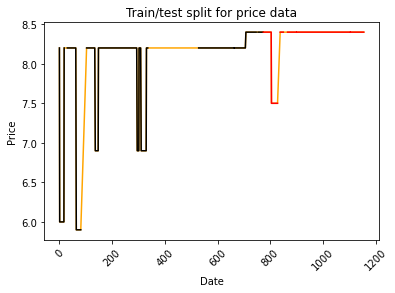

In [8]:
plt.plot(y_train, color = "orange")
plt.plot(y_test, color = "orange")
plt.plot(X_train, color = "black")
plt.plot(X_test, color = "red")
plt.ylabel('Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/test split for price data")
plt.show()

In [9]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.values.reshape(-1, 1))
X_test = scaler.transform(X_test.values.reshape(-1, 1))
y_train = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler.transform(y_test.values.reshape(-1, 1))

# Reshape the data to (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], 1, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 1, 1))

# Replace the 'nan' values with 0
X_train = np.nan_to_num(X_train, 0.0)
X_test = np.nan_to_num(X_test, 0.0)

In [10]:
# Track models performance
log_models = pd.DataFrame(columns=["Model","Train_MSE","Test_MSE"])

### Models

We will use in the following models the masking layer. It is used to ignore or "mask" certain values in the time series data that are not relevant and are missing, so that the model does not try to process them. This allows the models to focus on the actual values in the time series and improve the imputation of missing values.

#### Forward neural network (FFNN)

We will use FFNN since it is easy to implement and the ability to learn complex non-linear relationships.

In [11]:
# Define the model architecture
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

# Fit the model to the data
model.fit(X_train, y_train, epochs=100, batch_size=1, shuffle=True, verbose=0)

# Make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
orig_trainY = scaler.inverse_transform(y_train.reshape(len(y_train), 1))
testPredict = scaler.inverse_transform(testPredict)
orig_testY = scaler.inverse_transform(y_test.reshape(len(y_test), 1))

# Calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(orig_trainY[:,0], trainPredict[:,0]))
print('Train Score: %.5f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(orig_testY[:,0], testPredict[:,0]))
print('Test Score: %.5f RMSE' % (testScore))

log_models.loc[len(log_models)] = ['Feed forward neural network', trainScore ,testScore]

Train Score: 0.43501 RMSE
Test Score: 0.06732 RMSE


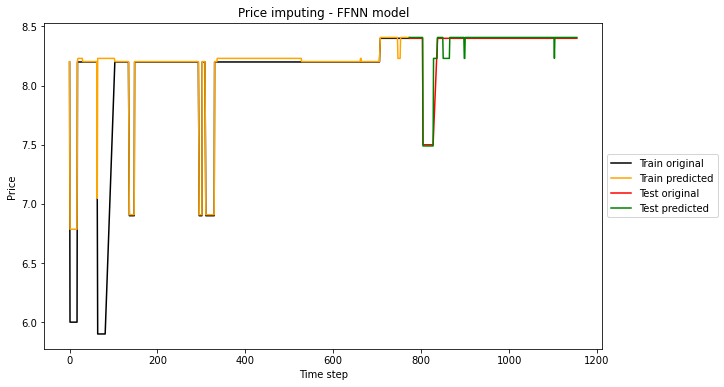

In [12]:
# Get the length of the train data
train_length = len(orig_trainY[:,0])

# Adjust the x-axis of the test data
x_test = range(train_length, train_length + len(orig_testY[:,0]))

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(range(len(orig_trainY[:,0])), orig_trainY[:,0], label='Train original', color="black")
plt.plot(range(len(trainPredict[:,0])), trainPredict[:,0], label='Train predicted', color="orange")
plt.plot(x_test, orig_testY[:,0], label='Test original', color="red")
plt.plot(x_test, testPredict[:,0], label='Test predicted', color="green")
plt.title('Price imputing - FFNN model')
plt.xlabel('Time step')
plt.ylabel('Price')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### Autoencoders

We will use autoencoders to reconstruct the missing data. This is done by training the autoencoder to learn the patterns within the data, and then using this knowledge to fill in the missing values.

In [13]:
# create and fit the autoencoder network

# Define encoder architecture
encoder_inputs = Input(shape=(X_train.shape[1],))
masked_input = Masking(mask_value=0.0)(encoder_inputs)
encoded = Dense(16, activation='relu')(masked_input)
encoded = Dense(4, activation='relu')(encoded)

# Define decoder architecture
decoded = Dense(4, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(decoded)
decoded = Dense(X_train.shape[1], activation='linear')(decoded)

# Define autoencoder model
autoencoder = Model(encoder_inputs, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_absolute_error')

# Fit the model to the data
autoencoder.fit(X_train, y_train, epochs=100, batch_size=1, shuffle=True, verbose=0)

# Make predictions
trainPredict = autoencoder.predict(X_train)
testPredict = autoencoder.predict(X_test)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
orig_trainY = scaler.inverse_transform(y_train.reshape(len(y_train), 1))
testPredict = scaler.inverse_transform(testPredict)
orig_testY = scaler.inverse_transform(y_test.reshape(len(y_test), 1))

# Calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(orig_trainY[:,0], trainPredict[:,0]))
print('Train Score: %.5f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(orig_testY[:,0], testPredict[:,0]))
print('Test Score: %.5f RMSE' % (testScore))

log_models.loc[len(log_models)] = ['Autoencoders', trainScore ,testScore]

Train Score: 1.17013 RMSE
Test Score: 0.60190 RMSE


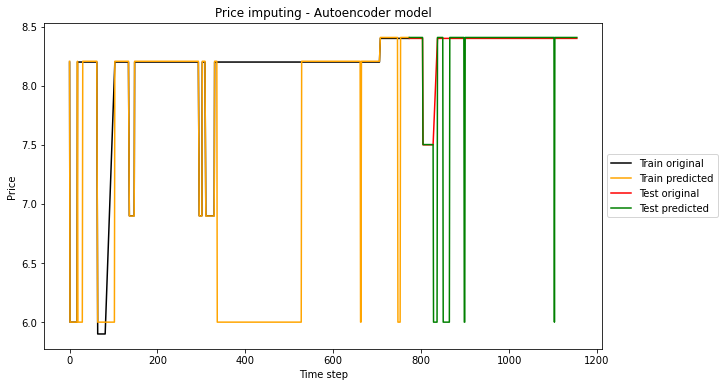

In [14]:
# Get the length of the train data
train_length = len(orig_trainY[:,0])

# Adjust the x-axis of the test data
x_test = range(train_length, train_length + len(orig_testY[:,0]))

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(range(len(orig_trainY[:,0])), orig_trainY[:,0], label='Train original', color="black")
plt.plot(range(len(trainPredict[:,0])), trainPredict[:,0], label='Train predicted', color="orange")
plt.plot(x_test, orig_testY[:,0], label='Test original', color="red")
plt.plot(x_test, testPredict[:,0], label='Test predicted', color="green")
plt.title('Price imputing - Autoencoder model')
plt.xlabel('Time step')
plt.ylabel('Price')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### Bidirectional RNN

Bidirectional RNN can take into account both past and future context when making predictions, thus, it captures dependencies between the missing data points and the surrounding data, which is crucial for imputation tasks.

In [15]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [16]:
# create and fit the bidirectional RNN network

# Define the model architecture
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(X_train.reshape(-1, 1).shape[1], 1)))
model.add(Bidirectional(SimpleRNN(32, return_sequences=True), input_shape=(X_train.shape[1], 1)))
model.add(Bidirectional(SimpleRNN(32)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(X_train.shape[1], activation='linear'))
# Compile the model
model.compile(optimizer='adam', loss='mse')
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=1, shuffle=True, verbose=0)


# Make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
orig_trainY = scaler.inverse_transform(y_train.reshape(len(y_train), 1))
testPredict = scaler.inverse_transform(testPredict)
orig_testY = scaler.inverse_transform(y_test.reshape(len(y_test), 1))

# Calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(orig_trainY[:,0], trainPredict[:,0]))
print('Train Score: %.5f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(orig_testY[:,0], testPredict[:,0]))
print('Test Score: %.5f RMSE' % (testScore))

log_models.loc[len(log_models)] = ['Bidirectional RNN', trainScore ,testScore]

Train Score: 0.38599 RMSE
Test Score: 0.10833 RMSE


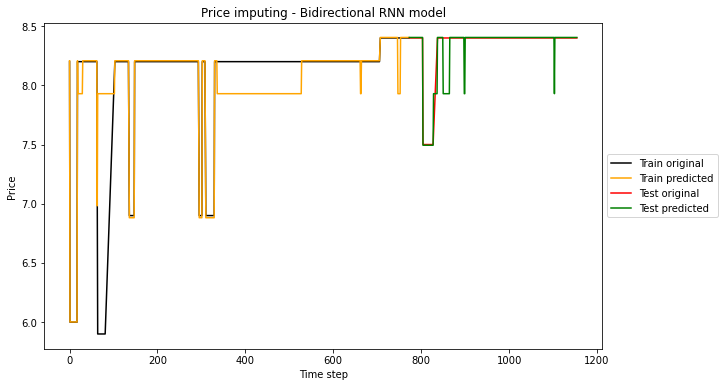

In [17]:
# Get the length of the train data
train_length = len(orig_trainY[:,0])

# Adjust the x-axis of the test data
x_test = range(train_length, train_length + len(orig_testY[:,0]))

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(range(len(orig_trainY[:,0])), orig_trainY[:,0], label='Train original', color="black")
plt.plot(range(len(trainPredict[:,0])), trainPredict[:,0], label='Train predicted', color="orange")
plt.plot(x_test, orig_testY[:,0], label='Test original', color="red")
plt.plot(x_test, testPredict[:,0], label='Test predicted', color="green")
plt.title('Price imputing - Bidirectional RNN model')
plt.xlabel('Time step')
plt.ylabel('Price')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Model comparison

In [18]:
# Present scores of all the models
log_models.sort_values(by="Test_MSE",ascending=True)

,Model,Train_MSE,Test_MSE
0,Feed forward neural network,0.408201,0.069511
2,Bidirectional RNN,0.392285,0.096424
1,Autoencoders,0.608856,0.261809


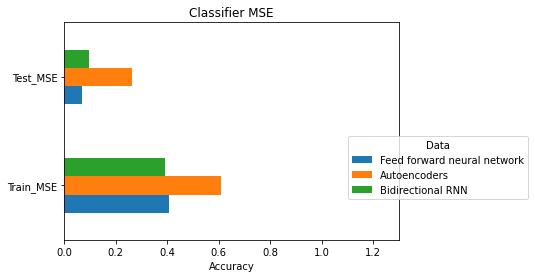

In [19]:
log_models.set_index('Model').T.plot.barh()
plt.title('Classifier MSE')
plt.legend(title='Data', bbox_to_anchor=(1.4, 0.5))
plt.xlabel('Accuracy')
plt.xlim((0.0,1.3))
plt.show()

By the comparison we see that the FFNN and the Bidirectional RNN model performed much better than the Autoencoder model.